# ACE2-RBD interaction analysis for different mutations

In this example we intend to analyze the interaction between ***human angiotensin converting enzyme 2 (ACE2)*** and the ***SARS-CoV-2 spike RBD domain***.
We want to compare, for the N501Y mutation, how ***electrostatic energies, Van der Waals energies and hydrogen bonds*** change on this residue and its surrounding residues.

For this test we will use RBD-ACE2 **atomistic MD trajectories** already loaded in the **[MDDB](https://irb.mddbr.eu) database**. Specifically, we will use a group of simulations from Mary Hongying Cheng including different varaints of the virus.

This workflow is based on the MDDB database REST API: https://irb.mddbr.eu/api/rest/docs/

***
**Version:** 1.0 (May 2025)
***
**Contributors:**  Adam Hospital, Daniel Beltrán, Aurélien Luciani, Genís Bayarri, Josep Lluís Gelpí, Modesto Orozco (IRB-Barcelona, Spain)
***
**Contact:** [daniel.beltran@irbbarcelona.org](mailto:daniel.beltran@irbbarcelona.org)
***

In [1]:
import urllib.request
import json

from numpy import mean

import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

# Set a dict to change residue 3 letters code to residue 1 letter code:
residue_letters = {
    'PRO' : 'P',
    'HIS' : 'H',
    'ARG' : 'R',
    'LYS' : 'K',
    'ILE' : 'I',
    'PHE' : 'F',
    'LEU' : 'L',
    'TRP' : 'W',
    'ALA' : 'A',
    'MET' : 'M',
    'CYS' : 'C',
    'ASN' : 'N',
    'VAL' : 'V',
    'GLY' : 'G',
    'SER' : 'S',
    'GLN' : 'Q',
    'TYR' : 'Y',
    'ASP' : 'D',
    'GLU' : 'E',
    'THR' : 'T',
    'CYX' : 'C',
    'HIE' : 'H',
    'HSD' : 'H',
}

Request the desired simulation projects through the API

In [2]:
# Set the URL to the MDDB REST API
api_url = 'https://irb.mddbr.eu/api/rest/v1/'

# Get a list with all simulations including the 'egfr' word in their names
simulations_request = api_url + 'projects?query={"metadata.AUTHORS":"Mary%20Hongying%20Cheng"}&limit=15'
with urllib.request.urlopen(simulations_request) as response:
    parsed_response = json.loads(response.read().decode("utf-8"))

available_simulations = parsed_response['projects']

Set a function to get reference residues from residue indices

We are going to focus in residue 501 and its surrounding residues. Use the project map to find these residues.

In [3]:
# DANI: Para consultar la topología hay que usar la API en "dev" de momento
dev_api_url = 'https://irb.mddbr.eu/api/rest/v1/'

# Set the residue numbers we are interested in. Use reference numeration
# In this example we are selecting residues close to residue 501
# The range was better fit after experimentaly observing which residues were relevant in this workflow
target_residues = list(range(482, 512))
reference_residue_index = target_residues.index(501)
target_reference = 'P0DTC2' # SARS-CoV-2 spike

# Mine each target sequence
# Use simulation accesion id as keys
target_sequences = {}

for simulation in available_simulations:
    # Get the simulation id and use it to request the simulation topology
    simulation_id = simulation['identifier']
    topology_request = dev_api_url + 'projects/' + simulation_id + '/topology'
    with urllib.request.urlopen(topology_request) as response:
        parsed_response = json.loads(response.read().decode("utf-8"))
    topology = parsed_response
    # Get the residue reference data in the topology
    references = topology['references']
    residue_reference_indices = topology['residue_reference_indices']
    residue_reference_numbers = topology['residue_reference_numbers']
    target_reference_index = references.index(target_reference)
    # Set a dictionary to easily relate residue reference numbers to residue indices for the target reference
    reference_indices = {}
    for i, residue_reference_number in enumerate(residue_reference_numbers):
        residue_reference_index = residue_reference_indices[i]
        if residue_reference_index != target_reference_index:
                continue
        reference_indices[residue_reference_number] = i
    # Now get the residue indices for each target residue
    target_residue_indices = [ reference_indices.get(target_residue, None) for target_residue in target_residues ]
    # Use these indices to get the actual aminoacids sequence
    residue_names = topology['residue_names']
    target_residue_names = [ residue_names[residue_index] for residue_index in target_residue_indices ]
    target_residue_letters = [ residue_letters[residue_name] for residue_name in target_residue_names ]
    sequence = ''.join(target_residue_letters)
    # Save some results in the project itself
    simulation['topology'] = topology
    simulation['target_residue_indices'] = target_residue_indices
    simulation['sequence'] = sequence
    # Display the sequence highlighting resiude 501 with parenthesis
    print(simulation['accession'] + ' -> '  + sequence[0:reference_residue_index] + '(' + sequence[reference_residue_index] + ')' + sequence[reference_residue_index+1:])

MCV1900410 -> GVEGFNCYFPLQSYGFQPT(N)GVGYQPYRVV
MCV1900413 -> GVEGFNCYFPLQSYGFQPT(Y)GVGYQPYRVV
MCV1900416 -> GVKGFNCYFPLQSYGFQPT(Y)GVGYQPYRVV
MCV1900419 -> GVEGFNCYFPLQSYGFQPT(N)GVGYQPYRVV
MCV1900422 -> GVKGFNCYFPLQSYGFQPT(Y)GVGYQPYRVV


As it can be observed in the previous logs, we have 6 simulations with the wild type residue (N) and 9 simulations with the mutation (Y) and the surrounding residues are equal in all 15 simulations.

Now we create two lists with the accessions of the 'N' and 'Y' simulations.

In [4]:
N501_simulations = []
Y501_simulations = []
for simulation in available_simulations:
    sequence = simulation['sequence']
    residue_501 = sequence[reference_residue_index]
    N501_simulations.append(simulation) if residue_501 == 'N' else Y501_simulations.append(simulation)

Set the API requests for project energies analysis data and interactions data

In [5]:
# Set a function to get the specific data energies we are interesed in
def get_energies_data (accession_or_id : str) -> dict:

    # Request the analysis
    analysis_request = api_url + 'projects/' + accession_or_id + '/analyses/energies'
    with urllib.request.urlopen(analysis_request) as response:
        parsed_response = json.loads(response.read().decode("utf-8"))
    analysis_data = parsed_response['data']

    # Get the indices of the target residues in the interaction list of residues
    # NOTE: Here we access the data using a known pattern:
    #   - ACE2-RBD interaction is the first (and usually the only) interaction in all ACE2-RBD simulations
    #   - RBD is always the second interacting agent in the interaction
    # However, if we did not know this, we could find the interaction and interacting agent as well
    # We would have to search for our target residue indices on each interaction and agent from interactions data
    interaction_data = analysis_data[0]
    rbd_data = interaction_data['agent2']

    # For this example, we are going to focus in the overall sum of energies
    energies_data = rbd_data['both']
    
    return energies_data

# Set a function to get interaction residue indices from a specific simulation
def get_interaction_residue_indices (accession_or_id : str) -> list:
    
    # Use the simulation id to request the simulation interactions data
    interactions_request = dev_api_url + 'projects/' + accession_or_id + '/analyses/interactions'
    with urllib.request.urlopen(interactions_request) as response:
        parsed_response = json.loads(response.read().decode("utf-8"))
    interactions = parsed_response
    
    # Get the indices of the target residues in the interaction list of residues
    # NOTE: Here we access the data using a known pattern:
    #   - ACE2-RBD interaction is the first (and usually the only) interaction in all ACE2-RBD simulations
    #   - RBD is always the second interacting agent in the interaction
    # However, if we did not know this, we could find the interaction and interacting agent as well
    # We would have to search for our target residue indices on each interaction and agent
    interaction = interactions[0]
    
    # We are interested in the RBD reisude indices
    return interaction['residue_indices_2']

Get the energies per residue and prepare a graph for each residue 501 variant

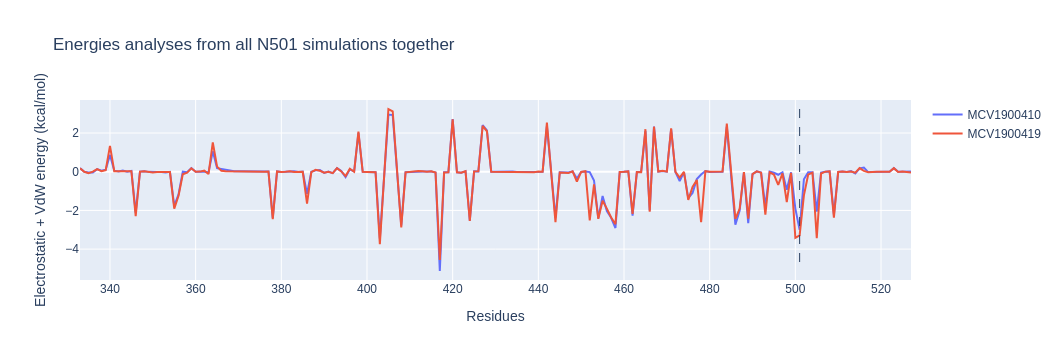

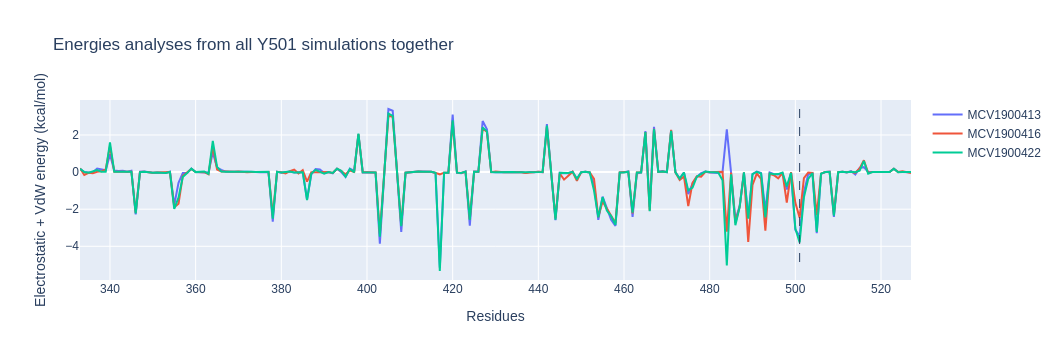

In [6]:
# Make a plot for each group of simulations
# Overlap all energies for each group
simulation_groups = { 'N501': N501_simulations, 'Y501': Y501_simulations }
# Store energies data for further use
energies_data = { 'N501': [], 'Y501': [] }
for group_name, simulations in simulation_groups.items():
    # Make a scatter for each energies result
    data = []
    all_energies = []
    for simulation in simulations:
        accession = simulation['accession']
        # Get residue indices for residues in the energies analysis
        rbd_interaction_residues = get_interaction_residue_indices(accession)
        # Convert residue indices to reference numeration
        residue_reference_numbers = simulation['topology']['residue_reference_numbers']
        rbd_interaction_residue_refs = [ residue_reference_numbers[i] for i in rbd_interaction_residues ]
        # Get the energies data
        energies = get_energies_data(accession)
        # Store apart energies + interactions data for further use
        energies_data[group_name].append({ 'energies': energies, 'residues': rbd_interaction_residues })
        # Save all energies together
        all_energies += energies
        # Generate the corresponding line for the plot
        data.append(
            go.Scatter(
                x = rbd_interaction_residue_refs,
                y = energies,
                name = accession,
                #hovertemplate = 'Residue %{x} (%{text}): %{y:.4f}',
                #text = residue_names,
            )
        )
    # Set a vertical lines to mark the mutated residue
    mutated_residue_x = 501
    max_value = max(all_energies)
    min_value = min(all_energies)
    shapes = [{
        'type': 'line',
        'line':{
            'dash': 'dash',
            'width': 1,
        },
        'xref': 'x',
        'yref': 'y',
        'x0': mutated_residue_x,
        'y0': max_value,
        'x1': mutated_residue_x,
        'y1': min_value
    }]
    # Show the figure of all energies overlapped
    fig = go.Figure({
        "data": data,
        "layout": go.Layout(
            title='Energies analyses from all ' + group_name + ' simulations together',
            xaxis={'title': 'Residues'},
            yaxis={'title': 'Electrostatic + VdW energy (kcal/mol)'},
            shapes=shapes
        )
    })
    fig.show()

To highlight the difference between the two aminoacid groups we will merge data by calculating averages and then we will overlap these values.<br />
This time we will plot only the region of residues we are focused in.

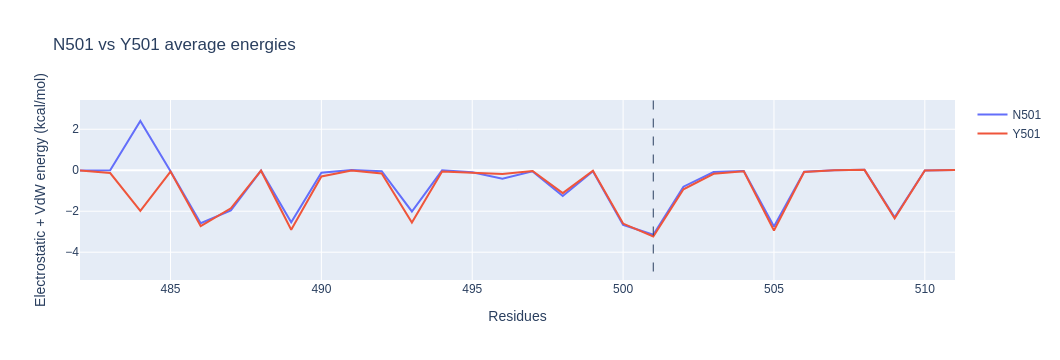

In [7]:
plot_data = []

# Get the residue indices for each target residue
# Note that we rely in the fact that all energies analyses have identical residue numbers
target_residue_indices = [ reference_indices.get(target_residue, None) for target_residue in target_residues ]

for group_name, energies_analyses in energies_data.items():
    # Calculate average energy values for target residues
    energies_avg = []
    for residue_index in target_residue_indices:
        energy_values = []
        for energies_analysis in energies_analyses:
            data_residue_index = energies_analysis['residues'].index(residue_index)
            energy_values.append(energies_analysis['energies'][data_residue_index])
        energies_avg.append(mean(energy_values))
    # Add data to the plot (last 60 residues only)
    plot_data.append(
        go.Scatter(
            x = target_residues,
            y = energies_avg,
            name = group_name,
        )
    )
    
# Show both average values overlapped to see the real difference
fig = go.Figure({
    "data": plot_data,
    "layout": go.Layout(
        title='N501 vs Y501 average energies',
        xaxis={'title': 'Residues'},
        yaxis={'title': 'Electrostatic + VdW energy (kcal/mol)'},
        shapes=shapes # We reuse the residue 501 mark from last cell
    )
})
fig.show()

# Show also the difference

The energies difference in the residue 501 region is not remarkable, althought there is a difference.<br />
Residue 501 has a 30% higher average energy when it is a tyrosine than when it is an aspargine.<br />
We can observe a high difference in residue 484, but this is because several simulations in the Y501 group have a N to K mutation in this residue (6 out of 9).

Now lets check hydrogen bonds

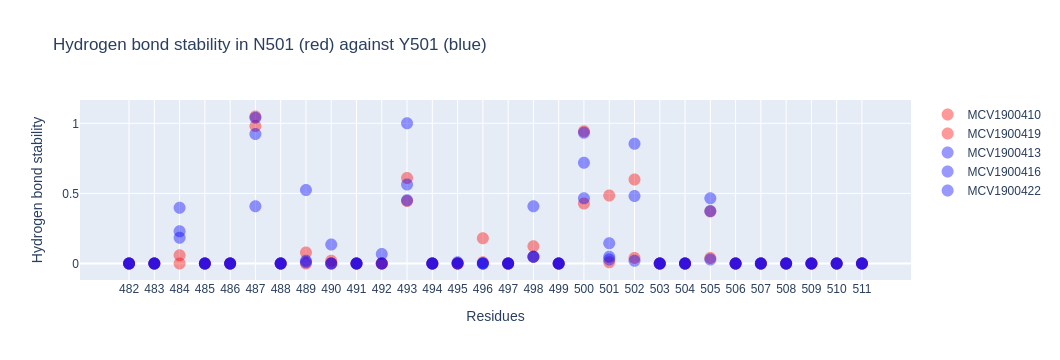

In [8]:
# Set a function to get the specific data energies we are interesed in
def get_hbonds_data (accession_or_id : str) -> dict:

    # Request the analysis
    analysis_request = api_url + 'projects/' + accession_or_id + '/analyses/hbonds'
    with urllib.request.urlopen(analysis_request) as response:
        parsed_response = json.loads(response.read().decode("utf-8"))
    analysis_data = parsed_response['data']

    # In this case, there is only one defined interaction: the protein-ligand interaction
    interaction_data = analysis_data[0]
    
    return interaction_data

# For each simulation, download hbonds data and find all hydrogen bonds in the target residues
colors = { 'N501': 'red', 'Y501': 'blue' }
hbonds_data = { 'N501': [], 'Y501': [] } # Store hbonds data for further use
plot_data = []
for group_name, simulations in simulation_groups.items():
    # Make a scatter for each energies result
    for simulation in simulations:
        simulation_id = simulation['identifier']
        accession = simulation['accession']
        # Get topology data and indices for target residues
        topology = simulation['topology']
        atom_residue_indices = topology['atom_residue_indices']
        target_residue_indices = simulation['target_residue_indices']
        # Get the hydrogen bonds data
        hbond_data = get_hbonds_data(simulation_id)
        # Get hydrogen bonds in the target residues
        acceptors = hbond_data['acceptors']
        donors = hbond_data['donors']
        hbonds = hbond_data['hbonds']
        target_hbonds = {}
        for i, target_residue_index in enumerate(target_residue_indices):
            # Find atom indices for all atoms in target residue
            target_atoms = [ atom_index for atom_index, residue_index in enumerate(atom_residue_indices) if residue_index == target_residue_index ]
            residue_stability = 0
            for j, hb in enumerate(hbonds):
                acceptor = acceptors[j]
                donor = donors[j]
                target_atom = next((atom for atom in [acceptor, donor] if atom in target_atoms), None)
                if not target_atom:
                    continue
                # Calculate the residue stability by adding all its hydrogen bond stabilities
                hbond_stability = sum(hb) / len(hb)
                residue_stability += hbond_stability
            # Set the final dataset to be displayed, using reference numeration for the residue labels
            target_residue_reference_number = target_residues[i]
            target_hbonds[target_residue_reference_number] = residue_stability
        hbonds_data[group_name].append(target_hbonds)
        # Generate the corresponding line for the plot
        plot_data.append(
            go.Scatter(
                x = list(target_hbonds.keys()),
                y = list(target_hbonds.values()),
                name = accession,
                opacity=0.4,
                marker={'color': colors[group_name], 'size': 12},
                mode="markers",
            )
        )
        
# Show the figure of all energies overlapped
fig = go.Figure({
    "data": plot_data,
    "layout": go.Layout(
        title= 'Hydrogen bond stability in N501 (red) against Y501 (blue)',
        xaxis={'title': 'Residues', 'tickvals': list(target_hbonds.keys())},
        yaxis={'title': 'Hydrogen bond stability'},
    )
})
fig.show()

Now to highligh differences we will use a boxplot with averages and standard deviations.<br />
We will also discard hydrogen bonds with 0 or near stability.

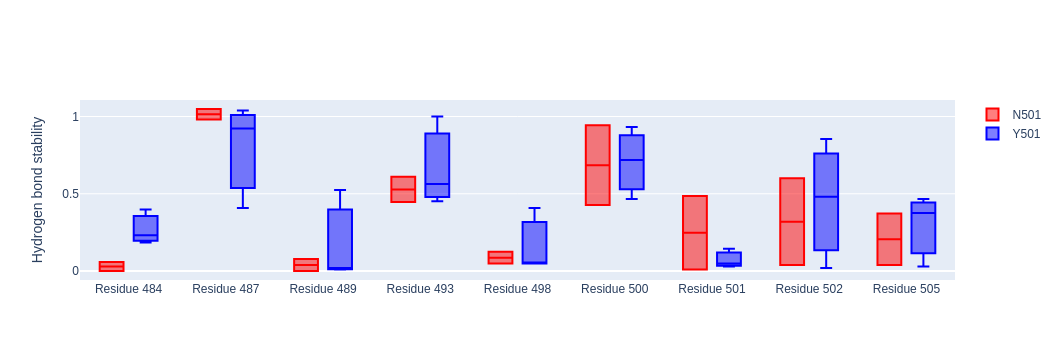

In [9]:
fig = go.Figure()

# Set the residues to be displayed
# Display only residues which reach a minimum of stability in at least one of the simulations in any group
minimum_stability_cutoff = 0.2
def is_displayed (residue : int) -> bool:
    for hbonds_analyses in hbonds_data.values():
        for hbonds_analysis in hbonds_analyses:
            if hbonds_analysis[residue] >= minimum_stability_cutoff:
                return True
    return False

display_residues = [residue for residue in target_residues if is_displayed(residue) ]

# Iterate over the groups
for group_name, hbonds_analyses in hbonds_data.items():
    x = []
    y = []
    for residue in display_residues:
        residue_stability_values = [ hb[residue] for hb in hbonds_analyses ]
        y += residue_stability_values
        # Literally repeate the name of the residue several times
        # This is useless for further sorting
        x += [ 'Residue ' + str(residue) for i in range(len(residue_stability_values)) ]
        
    box = go.Box(
        name = group_name,
        x = x, y = y,
        line = {'color':colors[group_name]}
    )
    fig.add_trace(box)

# Group together boxes of the same residue
fig.update_layout(
    yaxis_title='Hydrogen bond stability',
    # Group together boxes of the same residue
    boxmode='group'
)
fig.show()